In [1]:
import pandas as pd
import numpy as np
import xarray as xr
from scipy import stats
from random import random
from matplotlib import pyplot as plt
import cool_maps.plot as cplt
import cartopy.crs as ccrs
import matplotlib.dates as mdates

In [2]:
# List of file paths fot tag qualified tag detections (ECO-PAM missions from 2020, 2021, & 2022, and NJDEP Mission from 2022)
file_paths = [  'C:/Users/scott/Desktop/RUCOOL_Software_Bootcamp/Thesis coding/Qualified Detections/ecopam_qualified_detections_2022/ecopam_qualified_detections_2022.csv',
                'C:/Users/scott/Desktop/RUCOOL_Software_Bootcamp/Thesis coding/Qualified Detections/ecopam_qualified_detections_2021/ecopam_qualified_detections_2021.csv',
                'C:/Users/scott/Desktop/RUCOOL_Software_Bootcamp/Thesis coding/Qualified Detections/ecopam_qualified_detections_2020/ecopam_qualified_detections_2020.csv',
                'C:/Users/scott/Desktop/RUCOOL_Software_Bootcamp/Thesis coding/Qualified Detections/rmigliders_qualified_detections_2022/rmigliders_qualified_detections_2022.csv']

# Initialize an empty list to store DataFrames
all_detections = []

# Loop through each file path
for file_path in file_paths:
    # Read CSV file into DataFrame
    detection_data = pd.read_csv(file_path)
    # Convert 'datecollected' column to datetime
    detection_data['datecollected'] = pd.to_datetime(detection_data['datecollected'])
    
    # Append the DataFrame to the list
    all_detections.append(detection_data)

# Concatenate all DataFrames in the list into a single DataFrame
combined_detection_data = pd.concat(all_detections, ignore_index=True)

# Grab unique dates detections occured and convert to date format
unique_dates = combined_detection_data['datecollected'].dt.date.unique()

# empty column for water mass
combined_detection_data['WM'] = np.nan
# empty column for nearest Water Gradient above 1.5
combined_detection_data['WG'] = np.nan
# empty column for strongest Water Gradient within 1-km of detection
combined_detection_data['WG_1km'] = np.nan
# empty column for strongest Water Gradient within 5-km of detection
combined_detection_data['WG_5km'] = np.nan
# empty column for Distance to nearest Water Gradient above 1.5
combined_detection_data['WG_Dist'] = np.nan
# empty column for Species that corresponds to Tag ID (fieldnumber)
combined_detection_data['Species'] = np.nan

# Read in Biometric Tag ID Data
CSV = 'C:/Users/scott/Desktop/RUCOOL_Software_Bootcamp/Thesis coding/Master Tag Information Log 1.csv'
Species = pd.read_csv(CSV, sep=',', skiprows=range(1, 1))

# Merge the Species data into the combined_detection_data by Tag ID in the Biometric dataset and fieldnumber in the combined_detection_dataset
combined_detection_data = pd.merge(combined_detection_data, Species[['Tag ID', 'Species']], 
                                    how='left', left_on='fieldnumber', right_on='Tag ID')

# Drop the redundant 'Tag ID' column
combined_detection_data.drop(columns='Tag ID', inplace=True)


# open satellite dataset - looks like I used 8-day but you can change the link to match the dataset you want to use. this accesses thredds instead of ERDDAP, 
#similar idea but less browser-based functionality. you can basically use it as a regular netcdf file, without having to actually download the whole huge file.
#the full list of thredds datasets is here: http://basin.ceoe.udel.edu/thredds/catalog/catalog.html
satdata = xr.open_dataset('http://basin.ceoe.udel.edu/thredds/dodsC/Aqua1DayAggregate.nc')
# Subset to domain based on range of detections
satdata = satdata.sel(lon = slice(np.min(combined_detection_data['longitude'])-0.5, np.max(combined_detection_data['longitude'])+0.5),
                     lat = slice(np.min(combined_detection_data['latitude'])-0.5, np.max(combined_detection_data['latitude'])+0.5))
# Generate 2d lon and lag grid (for calculating distance)
satgrid = np.meshgrid(satdata['lon'], satdata['lat'])

# Define equation to get distance (km) from one lon/lat to another (or an entire set)
def haversine_dist(blon,blat,slon,slat):
    # blon: longitude of single point
    # blat: latitude of single point
    # slon: longitude(s) of grid
    # slat: latitude(s) of grid
    R = 6373.0
    blon=blon*np.pi/180
    blat=blat*np.pi/180
    slon=slon*np.pi/180
    slat=slat*np.pi/180
    dlon=slon-blon
    dlat=slat-blat
    a=np.sin(dlat/2)**2+np.cos(blat)*np.cos(slat)*np.sin(dlon/2)**2
    c=2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
    distance=R*c
    return distance

# initialize domain-based background conditions for water mass and frontal gradient
wmdomain=np.array(None)
wgdomain=np.array(None)

# loop through unique dates
for t in unique_dates:
    # find matching time in satellite data
    ti = np.logical_and(satdata['time'].data>=np.datetime64(t), satdata['time'].data<=np.datetime64(t)+np.timedelta64(1,'D'))
    # only continue if there is one (and only one) matching date in satellite data
    if np.sum(ti)==1:
        # grab water mass layer
        wm = np.squeeze(satdata['M_WK'][np.where(ti)[0],:,:].data)
        # grab frontal gradient layer
        wg = np.squeeze(satdata['M_WK_G'][np.where(ti)[0],:,:].data)
        # loop through detections on date t from all combined detections
        for detection in np.where(combined_detection_data['datecollected'].dt.date == t)[0]:
            # calculate distance from sighting location to satellite grid points
            d = haversine_dist(combined_detection_data['longitude'][detection], combined_detection_data['latitude'][detection],
                               satgrid[0], satgrid[1])
            # grab water mass classifications within 1km
            wm_close = wm[d <= 1]
            # grab frontal gradients within 1km
            wg_close = wg[d <= 1]
            # grab frontal gradients within 5km
            wg_close2 = wg[d <= 5]
            # grab maximum gradient within 1km and assign to dataframe
            combined_detection_data.loc[detection, 'WG_1km'] = np.max(wg_close)
            # grab maximum gradient within 5km and assign to dataframe
            combined_detection_data.loc[detection, 'WG_5km'] = np.max(wg_close2)
            # grab most common water mass category within 1km and assign to dataframe
            combined_detection_data.loc[detection, 'WM'] = stats.mode(wm_close, keepdims=False).mode
            # Find the index of the minimum distance
            min_dist_index = np.argmin(d)
            #if 1==2:
            if wg.flatten()[min_dist_index] > 1.5:
                # Assign the value of the nearest frontal gradient to the DataFrame
                combined_detection_data.at[detection, 'WG'] = wg.flatten()[min_dist_index]



In [3]:
unique_date_count = unique_dates.size
print("Number of unique dates:", unique_date_count)

Number of unique dates: 48


In [4]:
combined_detection_data

,basisofrecord,institutioncode,collectioncode,datelastmodified,datecollected,timezone,trackercode,fieldnumber,catalognumber,yearcollected,...,notes,tag_contact_pi,tag_contact_poc,WM,WG,WG_1km,WG_5km,WG_Dist,Species_x,Species_y
0,MachineObservation,RU-Marine,ECOPAM,10/19/2022,2022-01-30 02:05:00,UTC,SBUSOMAS01,A69-1602-49608,A69-1602-49608-2457,2022,...,NaN,Michael Frisk (michael.frisk@stonybrook.edu),NaN,51.0,NaN,0.0,0.0,NaN,NaN,NaN
1,MachineObservation,RU-Marine,ECOPAM,10/19/2022,2022-01-30 02:11:00,UTC,SBUSOMAS01,A69-1602-49608,A69-1602-49608-2458,2022,...,NaN,Michael Frisk (michael.frisk@stonybrook.edu),NaN,51.0,NaN,0.0,0.0,NaN,NaN,NaN
2,MachineObservation,RU-Marine,ECOPAM,10/19/2022,2022-01-30 02:15:00,UTC,SBUSOMAS01,A69-1602-49608,A69-1602-49608-2459,2022,...,NaN,Michael Frisk (michael.frisk@stonybrook.edu),NaN,51.0,NaN,0.0,0.0,NaN,NaN,NaN
3,MachineObservation,RU-Marine,ECOPAM,10/19/2022,2022-01-30 02:19:00,UTC,SBUSOMAS01,A69-1602-49608,A69-1602-49608-2460,2022,...,NaN,Michael Frisk (michael.frisk@stonybrook.edu),NaN,51.0,NaN,0.0,0.0,NaN,NaN,NaN
4,MachineObservation,RU-Marine,ECOPAM,10/19/2022,2022-01-30 02:20:00,UTC,SBUSOMAS01,A69-1602-49608,A69-1602-49608-2461,2022,...,NaN,Michael Frisk (michael.frisk@stonybrook.edu),NaN,51.0,NaN,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,MachineObservation,RU-Marine,RMIGLIDERS,2023-02-15,2022-09-20 23:20:38,UTC,SBUSOMAS01,A69-9001-64170,A69-9001-64170-13000,2022,...,NaN,Michael Frisk (michael.frisk@stonybrook.edu),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1063,MachineObservation,RU-Marine,RMIGLIDERS,2023-02-15,2022-09-20 23:25:46,UTC,SBUSOMAS01,A69-9001-64170,A69-9001-64170-13004,2022,...,NaN,Michael Frisk (michael.frisk@stonybrook.edu),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1064,MachineObservation,RU-Marine,RMIGLIDERS,2023-02-15,2022-09-20 23:39:42,UTC,SBUSOMAS01,A69-9001-64170,A69-9001-64170-13014,2022,...,NaN,Michael Frisk (michael.frisk@stonybrook.edu),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1065,MachineObservation,RU-Marine,RMIGLIDERS,2023-02-15,2022-09-30 00:03:22,UTC,SBUSOMAS01,A69-9001-64179,A69-9001-64179-21186,2022,...,NaN,Michael Frisk (michael.frisk@stonybrook.edu),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Group by 'WM', 'datecollected', and 'fieldnumber'
grouped = combined_detection_data.groupby(['WM', 'datecollected', 'fieldnumber'])

# Use transform to assign the first 'lat' and 'lon' of each group to new columns
combined_detection_data['first_lat'] = grouped['latitude'].transform('first')
combined_detection_data['first_lon'] = grouped['longitude'].transform('first')

In [6]:
# Make sure datecollected is in Date format 
combined_detection_data['datecollected'] = pd.to_datetime(combined_detection_data['datecollected']).dt.date
# Create a Multi Index
combined_detection_data.set_index(['WM', 'datecollected', 'fieldnumber'], inplace=True)

In [7]:
# Sort the index
combined_detection_data.sort_index(inplace=True)

In [8]:
# Define a function named 'assign_first_lat_lon_to_indexed_df' that accepts a DataFrame 'df' as its parameter
def assign_first_lat_lon_to_indexed_df(df):
    # Create a new DataFrame 'result_df' by copying the original DataFrame to preserve the original data
    result_df = df.copy()
    
    # Add new columns 'first_lat' and 'first_lon' to 'result_df', initially setting all their values to NaN (Not a Number)
    result_df['first_lat'] = np.nan
    result_df['first_lon'] = np.nan
    
    # Iterate over each unique group in the DataFrame 'df' identified by a combination of the MultiIndex levels ['WM', 'datecollected', 'fieldnumber']
    for index, group in df.groupby(level=['WM', 'datecollected', 'fieldnumber']):
        # Access the first row of each group to get the initial latitude and longitude
        first_row = group.iloc[0]  # iloc[0] selects the first row of the group
        
        # Update the 'first_lat' and 'first_lon' columns in 'result_df' for the corresponding indices of the group
        # Set them to the latitude and longitude values of the first row of the group
        result_df.loc[group.index, 'first_lat'] = first_row['latitude']
        result_df.loc[group.index, 'first_lon'] = first_row['longitude']
    
    # Return the modified DataFrame that now includes the 'first_lat' and 'first_lon' data for each group
    return result_df

# Apply the function 'assign_first_lat_lon_to_indexed_df' to the DataFrame 'combined_detection_data'
# This line calls the function and assigns the modified DataFrame back to 'combined_detection_data'
combined_detection_data = assign_first_lat_lon_to_indexed_df(combined_detection_data)


In [9]:
# Reset the Multi Index and grab first iteration of the multi Index (First detection for a unique fieldnumber on a unique day within a unique Water Mass)
grouped_data = combined_detection_data.groupby(['WM', 'datecollected', 'fieldnumber']).first().reset_index()

In [10]:
grouped_data

,WM,datecollected,fieldnumber,basisofrecord,institutioncode,collectioncode,datelastmodified,timezone,trackercode,catalognumber,...,tag_contact_pi,tag_contact_poc,WG,WG_1km,WG_5km,WG_Dist,Species_x,Species_y,first_lat,first_lon
0,43.0,2020-11-20,A69-9002-6773,MachineObservation,RU-Marine,ECOPAM,2021-04-13,UTC,MDWEA,A69-9002-6773-1750,...,David Secor (secor@umces.edu),Mike O'Brien (obrien@umces.edu),NaN,0.716318,1.796005,NaN,NaN,Striped Bass,39.28004,-74.18724
1,51.0,2020-12-10,A69-1602-20938,MachineObservation,RU-Marine,ECOPAM,2021-04-13,UTC,DEARRAY,A69-1602-20938-2043,...,Ian Park (ian.park@delaware.gov),Ian Park (ian.park@delaware.gov),NaN,1.593299,2.046302,NaN,NaN,Striped Bass,39.05235,-74.42598
2,51.0,2020-12-10,A69-1602-20952,MachineObservation,RU-Marine,ECOPAM,2021-04-13,UTC,DEARRAY,A69-1602-20952-2034,...,Ian Park (ian.park@delaware.gov),Ian Park (ian.park@delaware.gov),NaN,1.593816,2.046571,NaN,NaN,Striped Bass,39.06564,-74.42868
3,51.0,2020-12-10,A69-1602-20954,MachineObservation,RU-Marine,ECOPAM,2021-04-13,UTC,DEARRAY,A69-1602-20954-2007,...,Ian Park (ian.park@delaware.gov),Ian Park (ian.park@delaware.gov),NaN,1.593816,2.046571,NaN,NaN,Striped Bass,39.06807,-74.43343
4,51.0,2020-12-10,A69-9001-17812,MachineObservation,RU-Marine,ECOPAM,2021-04-13,UTC,DMFCS,A69-9001-17812-2039,...,Benjamin Gahagan (ben.gahagan@mass.gov),Benjamin Gahagan (ben.gahagan@mass.gov),NaN,1.593816,2.046571,NaN,NaN,Striped Bass,39.06470,-74.42849
5,51.0,2020-12-10,A69-9001-21793,MachineObservation,RU-Marine,ECOPAM,2021-04-13,UTC,DMFCS,A69-9001-21793-2006,...,Benjamin Gahagan (ben.gahagan@mass.gov),Benjamin Gahagan (ben.gahagan@mass.gov),NaN,1.593816,2.046571,NaN,NaN,Striped Bass,39.06821,-74.43357
6,51.0,2020-12-10,A69-9001-21830,MachineObservation,RU-Marine,ECOPAM,2021-04-13,UTC,DMFCS,A69-9001-21830-2012,...,Benjamin Gahagan (ben.gahagan@mass.gov),Benjamin Gahagan (ben.gahagan@mass.gov),NaN,1.593816,2.046571,NaN,NaN,Striped Bass,39.06711,-74.42898
7,51.0,2022-01-30,A69-1602-49608,MachineObservation,RU-Marine,ECOPAM,10/19/2022,UTC,SBUSOMAS01,A69-1602-49608-2457,...,Michael Frisk (michael.frisk@stonybrook.edu),None,NaN,0.000000,0.000000,NaN,NaN,None,38.99289,-74.15151
8,69.0,2020-10-06,A69-9001-21820,MachineObservation,RU-Marine,ECOPAM,2021-04-13,UTC,DMFCS,A69-9001-21820-1636,...,Benjamin Gahagan (ben.gahagan@mass.gov),Benjamin Gahagan (ben.gahagan@mass.gov),NaN,0.384349,NaN,NaN,NaN,Striped Bass,39.07816,-74.11490
9,72.0,2020-10-08,A69-9001-13443,MachineObservation,RU-Marine,ECOPAM,2021-07-14,UTC,MUFISH,A69-9001-13443-1638,...,Keith Dunton (kdunton@monmouth.edu),Keith Dunton (kdunton@monmouth.edu),NaN,0.000000,2.313137,NaN,NaN,Dusky shark,39.15431,-74.14990


In [11]:
print(combined_detection_data.describe()) 

       yearcollected  monthcollected  daycollected    julianday    timeofday  \
count    1067.000000     1067.000000   1067.000000  1067.000000  1067.000000   
mean     2021.090909        7.936270      9.149016   219.708529    10.727143   
std         0.986866        3.268714      8.053137   104.243187     7.529736   
min      2020.000000        1.000000      1.000000    18.000000     0.000833   
25%      2020.000000        6.000000      2.000000   153.000000     4.013750   
50%      2022.000000        6.000000      8.000000   153.000000    11.030278   
75%      2022.000000       12.000000     14.000000   344.000000    15.406111   
max      2022.000000       12.000000     30.000000   355.000000    23.980000   

       collectornumber     latitude    longitude  sensorname  sensorraw  \
count     1.067000e+03  1067.000000  1067.000000         0.0        0.0   
mean      4.913087e+05    39.047659   -74.408898         NaN        NaN   
std       1.863808e+05     0.215566     0.288252      

In [12]:
#Un-Do Multi Index
combined_detection_data.reset_index(inplace=True)

# Check if the index has been reset by printing the columns
print(combined_detection_data.columns)

# Drop rows where 'WM' column has NaN values
combined_detection_data = combined_detection_data.dropna(subset=['WM'])

# Re-index by 'WM', 'datecollected', and 'fieldnumber'
combined_detection_data.set_index(['WM', 'datecollected', 'fieldnumber'], inplace=True)

Index(['WM', 'datecollected', 'fieldnumber', 'basisofrecord',
       'institutioncode', 'collectioncode', 'datelastmodified', 'timezone',
       'trackercode', 'catalognumber', 'yearcollected', 'monthcollected',
       'daycollected', 'julianday', 'timeofday', 'station', 'collectornumber',
       'latitude', 'longitude', 'rcvrcatnumber', 'sensorname', 'sensorraw',
       'the_geom', 'notes', 'tag_contact_pi', 'tag_contact_poc', 'WG',
       'WG_1km', 'WG_5km', 'WG_Dist', 'Species_x', 'Species_y', 'first_lat',
       'first_lon'],
      dtype='object')


In [13]:
combined_detection_data

basisofrecord institutioncode  \
WM    datecollected fieldnumber                                          
43.0  2020-11-20    A69-9002-6773   MachineObservation       RU-Marine   
                    A69-9002-6773   MachineObservation       RU-Marine   
                    A69-9002-6773   MachineObservation       RU-Marine   
                    A69-9002-6773   MachineObservation       RU-Marine   
51.0  2020-12-10    A69-1602-20938  MachineObservation       RU-Marine   
...                                                ...             ...   
455.0 2022-06-02    A69-9001-5324   MachineObservation       RU-Marine   
                    A69-9001-5324   MachineObservation       RU-Marine   
                    A69-9001-5324   MachineObservation       RU-Marine   
                    A69-9001-5324   MachineObservation       RU-Marine   
                    A69-9001-5324   MachineObservation       RU-Marine   

                                   collectioncode datelastmodified timezone  \
WM    datecollected fieldnumber                                               
43.0  2020-11-20    A69-9002-6773          ECOPAM       2021-04-13      UTC   
                    A69-9002-6773          ECOPAM       2021-04-13      UTC   
                    A69-9002-6773          ECOPAM       2021-04-13      UTC   
                    A69-9002-6773          ECOPAM       2021-04-13      UTC   
51.0  2020-12-10    A69-1602-20938         ECOPAM       2021-04-13      UTC   
...                                           ...              ...      ...   
455.0 2022-06-02    A69-9001-5324          ECOPAM       10/24/2022      UTC   
                    A69-9001-5324          ECOPAM       10/24/2022      UTC   
                    A69-9001-5324          ECOPAM       10/24/2022      UTC   
                    A69-9001-5324          ECOPAM       10/24/2022      UTC   
                    A69-9001-5324          ECOPAM       10/24/2022      UTC   

                                      trackercode        catalognumber  \
WM    datecollected fieldnumber                                          
43.0  2020-11-20    A69-9002-6773           MDWEA   A69-9002-6773-1750   
                    A69-9002-6773           MDWEA   A69-9002-6773-1751   
                    A69-9002-6773           MDWEA   A69-9002-6773-1752   
                    A69-9002-6773           MDWEA   A69-9002-6773-1753   
51.0  2020-12-10    A69-1602-20938        DEARRAY  A69-1602-20938-2043   
...                                           ...                  ...   
455.0 2022-06-02    A69-9001-5324   FACT.SCDNRGPD   A69-9001-5324-3026   
                    A69-9001-5324   FACT.SCDNRGPD   A69-9001-5324-2875   
                    A69-9001-5324   FACT.SCDNRGPD   A69-9001-5324-2980   
                    A69-9001-5324   FACT.SCDNRGPD   A69-9001-5324-2586   
                    A69-9001-5324   FACT.SCDNRGPD   A69-9001-5324-2732   

                                    yearcollected  monthcollected  \
WM    datecollected fieldnumber                                     
43.0  2020-11-20    A69-9002-6773            2020              11   
                    A69-9002-6773            2020              11   
                    A69-9002-6773            2020              11   
                    A69-9002-6773            2020              11   
51.0  2020-12-10    A69-1602-20938           2020              12   
...                                           ...             ...   
455.0 2022-06-02    A69-9001-5324            2022               6   
                    A69-9001-5324            2022               6   
                    A69-9001-5324            2022               6   
                    A69-9001-5324            2022               6   
                    A69-9001-5324            2022               6   

                                    daycollected  ...  \
WM    datecollected fieldnumber                   ...   
43.0  2020-11-20    A69-9002-6773             20  ...   
                  

In [14]:
# Reset the index to work with 'WM', 'datecollected', and 'fieldnumber' as columns
combined_detection_data.reset_index(inplace=True)

# Use duplicated to mark duplicates in 'fieldnumber' within each group of 'WM' and 'datecollected'
duplicates = combined_detection_data.duplicated(subset=['WM', 'datecollected', 'fieldnumber'], keep='first')

# Drop the duplicates
combined_detection_data = combined_detection_data[~duplicates]

# Set the index back to 'WM', 'datecollected', and 'fieldnumber'
combined_detection_data.set_index(['WM', 'datecollected', 'fieldnumber'], inplace=True)


In [15]:
# Drop the redundant 'species_x' column
combined_detection_data.drop(columns=['Species_x'], inplace=True)

# Rename the 'species_y' column to 'Species'
combined_detection_data.rename(columns={'Species_y': 'Species'}, inplace=True)

In [16]:
combined_detection_data

basisofrecord institutioncode  \
WM    datecollected fieldnumber                                          
43.0  2020-11-20    A69-9002-6773   MachineObservation       RU-Marine   
51.0  2020-12-10    A69-1602-20938  MachineObservation       RU-Marine   
                    A69-1602-20952  MachineObservation       RU-Marine   
                    A69-1602-20954  MachineObservation       RU-Marine   
                    A69-9001-17812  MachineObservation       RU-Marine   
                    A69-9001-21793  MachineObservation       RU-Marine   
                    A69-9001-21830  MachineObservation       RU-Marine   
      2022-01-30    A69-1602-49608  MachineObservation       RU-Marine   
69.0  2020-10-06    A69-9001-21820  MachineObservation       RU-Marine   
72.0  2020-10-08    A69-9001-13443  MachineObservation       RU-Marine   
      2020-10-22    A69-9001-12730  MachineObservation       RU-Marine   
      2020-10-24    A69-9001-6464   MachineObservation       RU-Marine   
      2020-12-11    A69-9001-18629  MachineObservation       RU-Marine   
307.0 2020-08-18    A69-9001-23325  MachineObservation       RU-Marine   
      2022-09-09    A69-9001-64170  MachineObservation       RU-Marine   
412.0 2022-03-04    A69-9001-23978  MachineObservation       RU-Marine   
418.0 2022-03-04    A69-9001-23978  MachineObservation       RU-Marine   
451.0 2022-06-02    A69-9001-12078  MachineObservation       RU-Marine   
                    A69-9001-5324   MachineObservation       RU-Marine   
455.0 2020-12-18    A69-9001-23922  MachineObservation       RU-Marine   
      2022-06-02    A69-9001-12078  MachineObservation       RU-Marine   
                    A69-9001-5324   MachineObservation       RU-Marine   

                                   collectioncode datelastmodified timezone  \
WM    datecollected fieldnumber                                               
43.0  2020-11-20    A69-9002-6773          ECOPAM       2021-04-13      UTC   
51.0  2020-12-10    A69-1602-20938         ECOPAM       2021-04-13      UTC   
                    A69-1602-20952         ECOPAM       2021-04-13      UTC   
                    A69-1602-20954         ECOPAM       2021-04-13      UTC   
                    A69-9001-17812         ECOPAM       2021-04-13      UTC   
                    A69-9001-21793         ECOPAM       2021-04-13      UTC   
                    A69-9001-21830         ECOPAM       2021-04-13      UTC   
      2022-01-30    A69-1602-49608         ECOPAM       10/19/2022      UTC   
69.0  2020-10-06    A69-9001-21820         ECOPAM       2021-04-13      UTC   
72.0  2020-10-08    A69-9001-13443         ECOPAM       2021-07-14      UTC   
      2020-10-22    A69-9001-12730         ECOPAM       2022-10-24      UTC   
      2020-10-24    A69-9001-6464          ECOPAM       2021-07-14      UTC   
      2020-12-11    A69-9001-18629         ECOPAM       2021-11-10      UTC   
307.0 2020-08-18    A69-9001-23325         ECOPAM       2021-04-13      UTC   
      2022-09-09    A69-9001-64170     RMIGLIDERS       2023-02-15      UTC   
412.0 2022-03-04    A69-9001-23978         ECOPAM        11/2/2023      UTC   
418.0 2022-03-04    A69-9001-23978         ECOPAM        11/2/2023      UTC   
451.0 2022-06-02    A69-9001-12078         ECOPAM       10/24/2022      UTC   
                    A69-9001-5324          ECOPAM       10/24/2022      UTC   
455.0 2020-12-18    A69-9001-23922         ECOPAM       2021-07-14      UTC   
      2022-06-02    A69-9001-12078         ECOPAM       10/24/2022      UTC   
                    A69-9001-5324          ECOPAM       10/24/2022      UTC   

                                      trackercode        catalognumber  \
WM    datecollected fieldnumber                                          
43.0  2020-11-20    A69-9002-6773           MDWEA   A69-9002-6773-1750   
51.0  2020-12-10    A69-1602-20938        DEARRAY  A69-1602-20938-2043   
                    A69-1602-20952        DEARRAY  A69-1602-20952-2034 

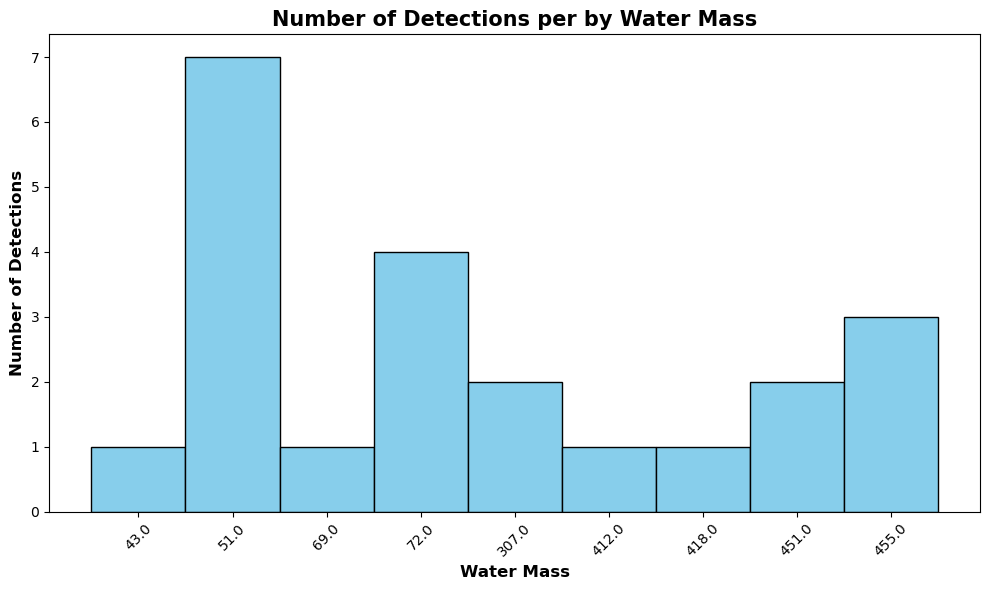

In [17]:
# Un-Do Index
combined_detection_data_reset = combined_detection_data.reset_index()

# Assign Water Mass Values as Categories
wm_categories = combined_detection_data_reset['WM'].astype('category').cat.codes


plt.figure(figsize=(10, 6))  
# Create a Histogram that shows the number of Detections for each water mass
plt.hist(wm_categories, bins=np.arange(len(combined_detection_data_reset['WM'].unique()) + 1) - 0.5, color='skyblue', edgecolor='black')
plt.title('Number of Detections per by Water Mass', fontsize=15, fontweight='bold')
plt.xlabel('Water Mass', fontsize=12, fontweight='bold')
plt.ylabel('Number of Detections', fontsize=12, fontweight='bold')
plt.xticks(range(len(combined_detection_data_reset['WM'].unique())), combined_detection_data_reset['WM'].unique(), rotation=45)
plt.tight_layout() 
plt.savefig('C:/Users/scott/Desktop/RUCOOL_Software_Bootcamp/Number of Detections per by Water Mass.png', dpi=300, bbox_inches='tight')
plt.show()



In [18]:
combined_detection_data_reset

,WM,datecollected,fieldnumber,basisofrecord,institutioncode,collectioncode,datelastmodified,timezone,trackercode,catalognumber,...,notes,tag_contact_pi,tag_contact_poc,WG,WG_1km,WG_5km,WG_Dist,Species,first_lat,first_lon
0,43.0,2020-11-20,A69-9002-6773,MachineObservation,RU-Marine,ECOPAM,2021-04-13,UTC,MDWEA,A69-9002-6773-1750,...,NaN,David Secor (secor@umces.edu),Mike O'Brien (obrien@umces.edu),NaN,0.716318,1.796005,NaN,Striped Bass,39.28004,-74.18724
1,51.0,2020-12-10,A69-1602-20938,MachineObservation,RU-Marine,ECOPAM,2021-04-13,UTC,DEARRAY,A69-1602-20938-2043,...,NaN,Ian Park (ian.park@delaware.gov),Ian Park (ian.park@delaware.gov),NaN,1.593299,2.046302,NaN,Striped Bass,39.05235,-74.42598
2,51.0,2020-12-10,A69-1602-20952,MachineObservation,RU-Marine,ECOPAM,2021-04-13,UTC,DEARRAY,A69-1602-20952-2034,...,NaN,Ian Park (ian.park@delaware.gov),Ian Park (ian.park@delaware.gov),NaN,1.593816,2.046571,NaN,Striped Bass,39.06564,-74.42868
3,51.0,2020-12-10,A69-1602-20954,MachineObservation,RU-Marine,ECOPAM,2021-04-13,UTC,DEARRAY,A69-1602-20954-2007,...,NaN,Ian Park (ian.park@delaware.gov),Ian Park (ian.park@delaware.gov),NaN,1.593816,2.046571,NaN,Striped Bass,39.06807,-74.43343
4,51.0,2020-12-10,A69-9001-17812,MachineObservation,RU-Marine,ECOPAM,2021-04-13,UTC,DMFCS,A69-9001-17812-2039,...,NaN,Benjamin Gahagan (ben.gahagan@mass.gov),Benjamin Gahagan (ben.gahagan@mass.gov),NaN,1.593816,2.046571,NaN,Striped Bass,39.06470,-74.42849
5,51.0,2020-12-10,A69-9001-21793,MachineObservation,RU-Marine,ECOPAM,2021-04-13,UTC,DMFCS,A69-9001-21793-2006,...,NaN,Benjamin Gahagan (ben.gahagan@mass.gov),Benjamin Gahagan (ben.gahagan@mass.gov),NaN,1.593816,2.046571,NaN,Striped Bass,39.06821,-74.43357
6,51.0,2020-12-10,A69-9001-21830,MachineObservation,RU-Marine,ECOPAM,2021-04-13,UTC,DMFCS,A69-9001-21830-2012,...,NaN,Benjamin Gahagan (ben.gahagan@mass.gov),Benjamin Gahagan (ben.gahagan@mass.gov),NaN,1.593816,2.046571,NaN,Striped Bass,39.06711,-74.42898
7,51.0,2022-01-30,A69-1602-49608,MachineObservation,RU-Marine,ECOPAM,10/19/2022,UTC,SBUSOMAS01,A69-1602-49608-2457,...,NaN,Michael Frisk (michael.frisk@stonybrook.edu),NaN,NaN,0.000000,0.000000,NaN,NaN,38.99289,-74.15151
8,69.0,2020-10-06,A69-9001-21820,MachineObservation,RU-Marine,ECOPAM,2021-04-13,UTC,DMFCS,A69-9001-21820-1636,...,NaN,Benjamin Gahagan (ben.gahagan@mass.gov),Benjamin Gahagan (ben.gahagan@mass.gov),NaN,0.384349,NaN,NaN,Striped Bass,39.07816,-74.11490
9,72.0,2020-10-08,A69-9001-13443,MachineObservation,RU-Marine,ECOPAM,2021-07-14,UTC,MUFISH,A69-9001-13443-1638,...,NaN,Keith Dunton (kdunton@monmouth.edu),Keith Dunton (kdunton@monmouth.edu),NaN,0.000000,2.313137,NaN,Dusky shark,39.15431,-74.14990


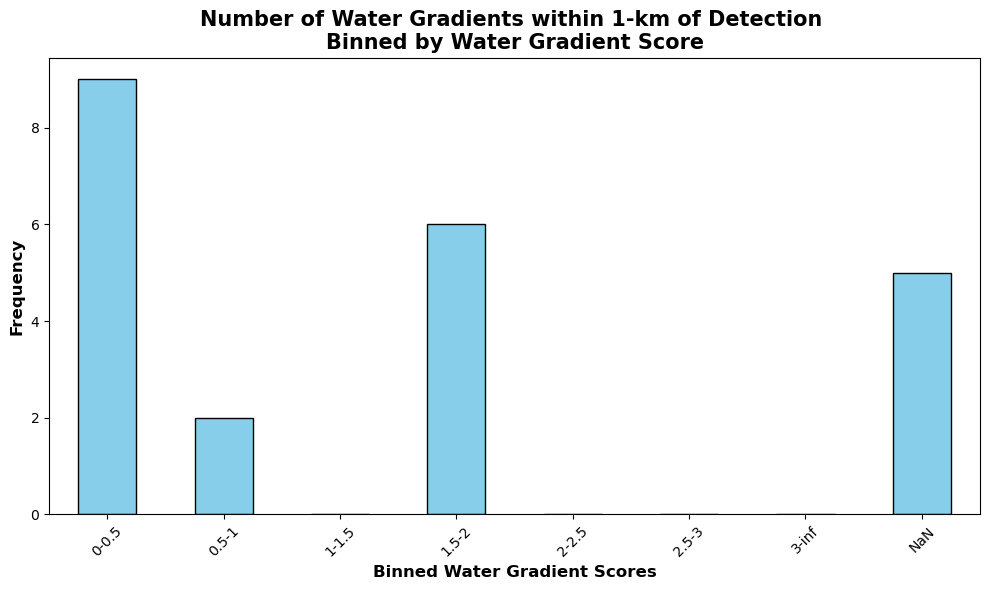

In [19]:
# Un-Do Index
combined_detection_data_reset = combined_detection_data.reset_index()

# Set Up Bins for water gradient scores and populate them for within 1-km of the detection
bin_edges = [0, 0.5, 1, 1.5, 2, 2.5, 3, np.inf]
bin_labels = [f'{bin_edges[i]}-{bin_edges[i+1]}' if i < len(bin_edges) - 1 else f'{bin_edges[i]}+' for i in range(len(bin_edges) - 1)]
combined_detection_data_reset['WG_1km_bins'] = pd.cut(combined_detection_data_reset['WG_1km'], bins=bin_edges, labels=bin_labels, right=False, include_lowest=True)

# Get the count of Detections within each bin
bin_counts = combined_detection_data_reset['WG_1km_bins'].value_counts().sort_index()
# Get a Count of the NaN values within the WG_1km column
nan_count = combined_detection_data_reset['WG_1km_bins'].isna().sum()
bin_counts['NaN'] = nan_count

plt.figure(figsize=(10, 6))  
# Create bar graph of the count of detections within each bin based on the strongest water gradient score within 1 km
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Water Gradients within 1-km of Detection \nBinned by Water Gradient Score', fontsize=15, fontweight='bold')
plt.xlabel('Binned Water Gradient Scores', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.savefig('C:/Users/scott/Desktop/RUCOOL_Software_Bootcamp/Number of Water Gradients within 1-km of Detection Binned by Water Gradient Score.png', dpi=300, bbox_inches='tight')
plt.show()


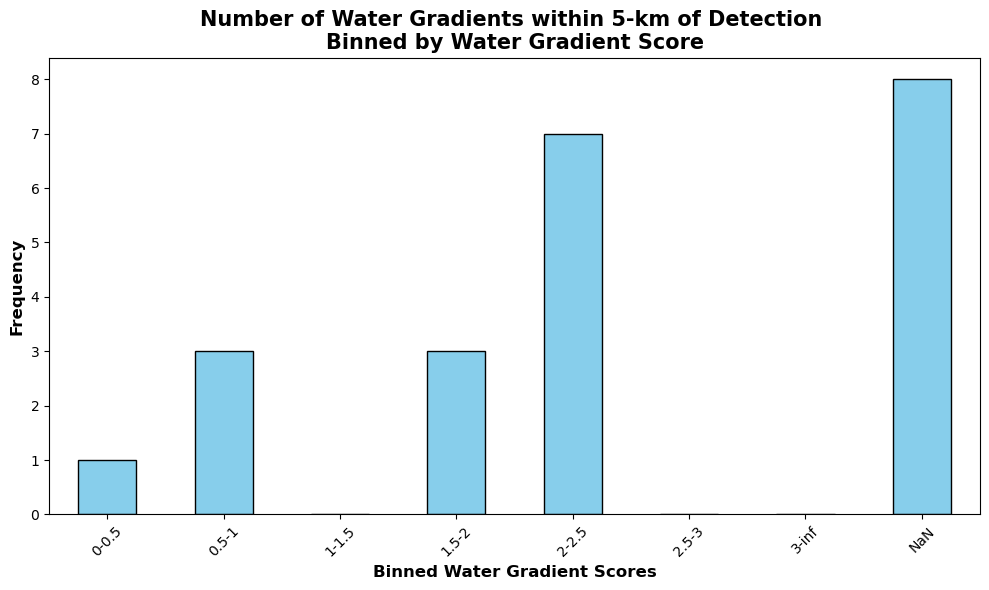

In [20]:
# Un-Do Index
combined_detection_data_reset = combined_detection_data.reset_index()

# Set Up Bins for water gradient scores and populate them for within 5-km of the detection
bin_edges = [0, 0.5, 1, 1.5, 2, 2.5, 3, np.inf]
bin_labels = [f'{bin_edges[i]}-{bin_edges[i+1]}' if i < len(bin_edges) - 1 else f'{bin_edges[i]}+' for i in range(len(bin_edges) - 1)]
combined_detection_data_reset['WG_5km_bins'] = pd.cut(combined_detection_data_reset['WG_5km'], bins=bin_edges, labels=bin_labels, right=False, include_lowest=True)

# Get the count of Detections within each bin
bin_counts = combined_detection_data_reset['WG_5km_bins'].value_counts().sort_index()

# Get a Count of the NaN values within the WG_1km column
nan_count = combined_detection_data_reset['WG_5km_bins'].isna().sum()
bin_counts['NaN'] = nan_count

plt.figure(figsize=(10, 6))  
# Create bar graph of the count of detections within each bin based on the strongest water gradient score within 1 km
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Water Gradients within 5-km of Detection \nBinned by Water Gradient Score', fontsize=15, fontweight='bold')
plt.xlabel('Binned Water Gradient Scores', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.savefig('C:/Users/scott/Desktop/RUCOOL_Software_Bootcamp/Number of Water Gradients within 5-km of Detection Binned by Water Gradient Score.png', dpi=300, bbox_inches='tight')
plt.show()


<Figure size 1000x600 with 0 Axes>

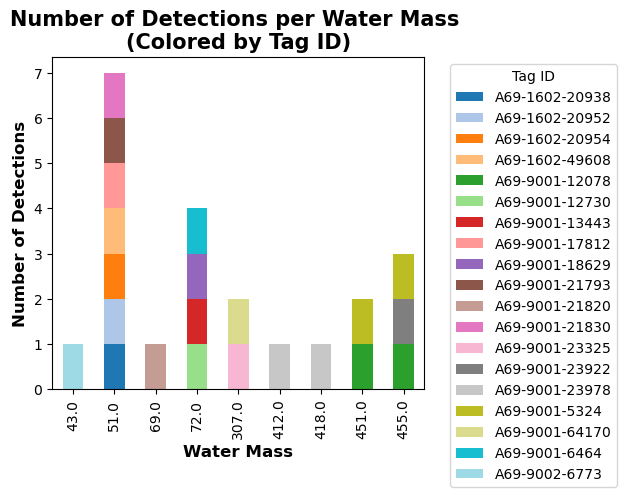

In [21]:
# Counts occurrences of data for each combination of 'fieldnumber' and 'WM'
# organizing the results into a table where rows represent 'fieldnumber' and columns represent 'WM' categories
counts = combined_detection_data_reset.groupby(['fieldnumber', 'WM']).size().unstack(fill_value=0)

# Transpose the counts DataFrame so that water masses become columns
counts = counts.T

plt.figure(figsize=(10, 6)) 
# Create a stacked histogram of number of tag detections for each water mass, colored by unique fieldnumbers
counts.plot(kind='bar', stacked=True, colormap='tab20')
plt.title('Number of Detections per Water Mass \n(Colored by Tag ID)', fontsize=15, fontweight='bold')
plt.xlabel('Water Mass', fontsize=12, fontweight='bold')
plt.ylabel('Number of Detections', fontsize=12, fontweight='bold')
plt.legend(title='Tag ID', bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.tight_layout()  
plt.savefig('C:/Users/scott/Desktop/RUCOOL_Software_Bootcamp/Number of Detections per Water Mass (Colored by Tag ID).png', dpi=300, bbox_inches='tight')
plt.show()


<Figure size 1000x600 with 0 Axes>

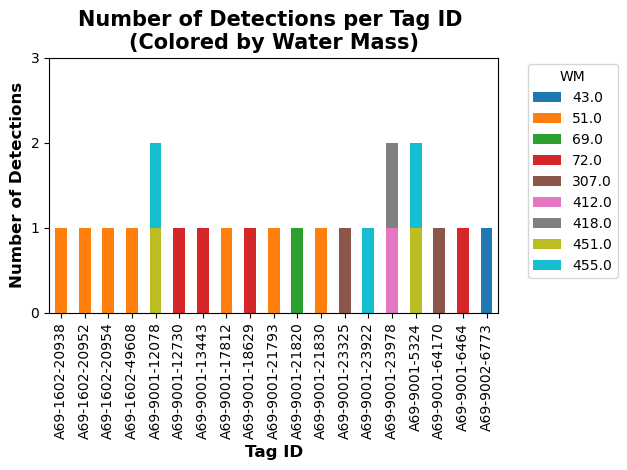

In [22]:
# Counts occurrences of data for each combination of 'fieldnumber' and 'WM'
# organizing the results into a table where rows represent 'fieldnumber' and columns represent 'WM' categories
counts = combined_detection_data_reset.groupby(['fieldnumber', 'WM']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6)) 
# Create a stacked histgram for number of dettctions for each Tag ID and color by the water mass they were detected in
counts.plot(kind='bar', stacked=True, colormap='tab10')
plt.title('Number of Detections per Tag ID \n(Colored by Water Mass)', fontsize=15, fontweight='bold')
plt.xlabel('Tag ID', fontsize=12, fontweight='bold')
plt.ylabel('Number of Detections', fontsize=12, fontweight='bold')
plt.ylim(0, 3) 
plt.locator_params(axis='y', nbins=3) 
plt.legend(title='WM', bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.tight_layout()
plt.savefig('C:/Users/scott/Desktop/RUCOOL_Software_Bootcamp/Number of Detections per Tag ID (Color Coded by WM).png', dpi=300, bbox_inches='tight')
plt.show()


<Figure size 1400x800 with 0 Axes>

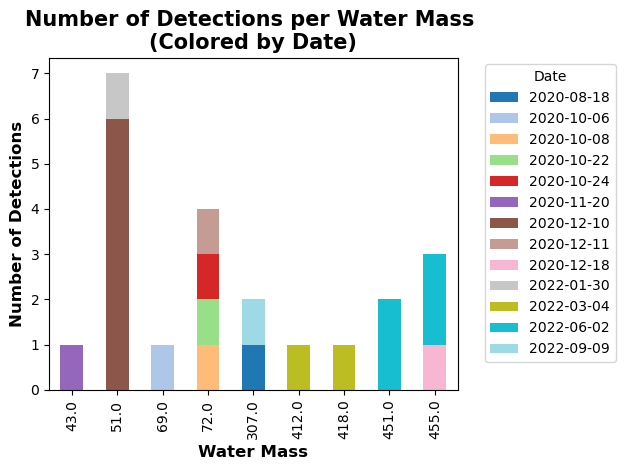

In [23]:
# Counts occurrences of data for each combination of 'WM' and 'datecollected'
# organizing the results into a table where rows represent 'WM' and columns represent 'datecollected' categories
counts = combined_detection_data_reset.groupby(['WM', 'datecollected']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 8)) 
# Create a stacked histogram showing number of detections by water mass colored by date of detections
counts.plot(kind='bar', stacked=True, colormap='tab20')
plt.title('Number of Detections per Water Mass \n(Colored by Date)', fontsize=15, fontweight='bold')
plt.xlabel('Water Mass', fontsize=12, fontweight='bold')
plt.ylabel('Number of Detections', fontsize=12, fontweight='bold')
plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.tight_layout()  
plt.savefig('C:/Users/scott/Desktop/RUCOOL_Software_Bootcamp/Number of Detections per Water Mass Colored by Date.png', dpi=300, bbox_inches='tight')
plt.show()


<Figure size 1000x1000 with 0 Axes>

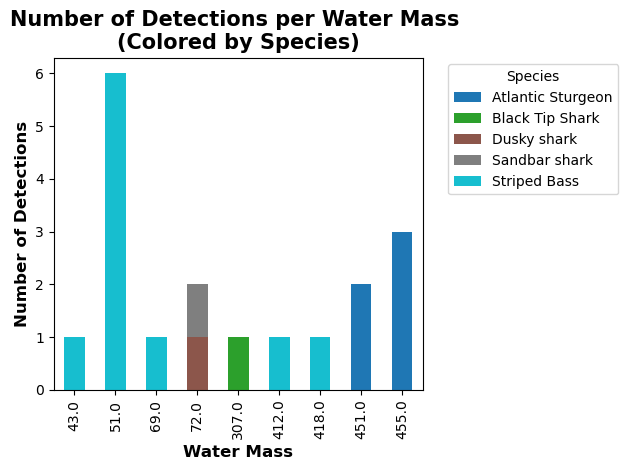

In [24]:
# Counts occurrences of data for each combination of 'Species' and 'WM'
# organizing the results into a table where rows represent 'Species' and columns represent 'WM' categories
counts = combined_detection_data_reset.groupby(['Species', 'WM']).size().unstack(fill_value=0)

# Transpose the counts DataFrame so that water masses become columns
counts = counts.T

plt.figure(figsize=(10, 10))
# Create a stacked histogram showing the number of detections for each water mass colored by Species / If Species was NaN it was excluded
counts.plot(kind='bar', stacked=True, colormap='tab10')
plt.title('Number of Detections per Water Mass \n(Colored by Species)', fontsize=15, fontweight='bold')
plt.xlabel('Water Mass', fontsize=12, fontweight='bold')
plt.ylabel('Number of Detections', fontsize=12, fontweight='bold')
plt.legend(title='Species', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('C:/Users/scott/Desktop/RUCOOL_Software_Bootcamp/Number of Detections per Water Mass Colored by Species.png', dpi=300, bbox_inches='tight')
plt.show()


<Figure size 1000x1000 with 0 Axes>

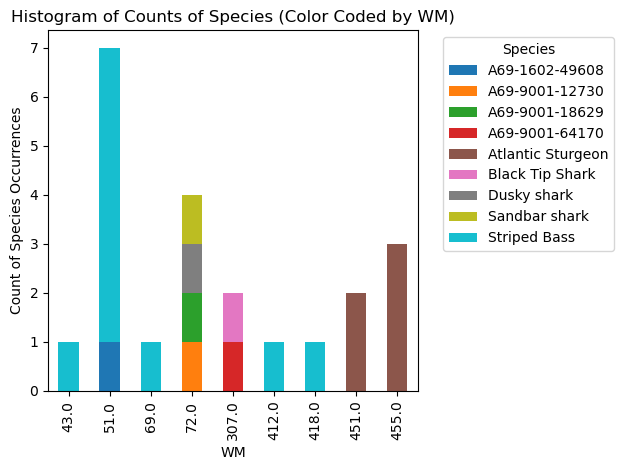

In [25]:
# Inserts the fieldnumber in the species column if no species is present
combined_detection_data_reset['Species'] = combined_detection_data_reset.apply(
    lambda row: row['fieldnumber'] if pd.isna(row['Species']) else row['Species'], axis=1)
# Counts occurrences of data for each combination of 'Species' and 'WM'
# organizing the results into a table where rows represent 'Species' and columns represent 'WM' categories
counts = combined_detection_data_reset.groupby(['Species', 'WM']).size().unstack(fill_value=0)

# Transpose the counts DataFrame so that water masses become columns
counts = counts.T

plt.figure(figsize=(10, 10))
# Create a stacked histogram showing the number of detections for each water mass colored by Species/ includes fieldnumbers where no biometric data was recieved
counts.plot(kind='bar', stacked=True, colormap='tab10')
plt.title('Histogram of Counts of Species (Color Coded by WM)')
plt.xlabel('WM')
plt.ylabel('Count of Species Occurrences')
plt.legend(title='Species', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()